<a href="https://colab.research.google.com/github/albim72/MACHINE_DEEP_05/blob/main/overfitting_full2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [32]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-a5va_a9a
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-a5va_a9a
  Resolved https://github.com/tensorflow/docs to commit 5d7c4c291249a7c7e149316ef0ac5eb86fd2cda1
  Preparing metadata (setup.py) ... done


In [33]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [34]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [35]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

In [36]:
#zbiór Higgsa
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [37]:
FEATURES = 28

In [38]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type='GZIP')

In [39]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [40]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


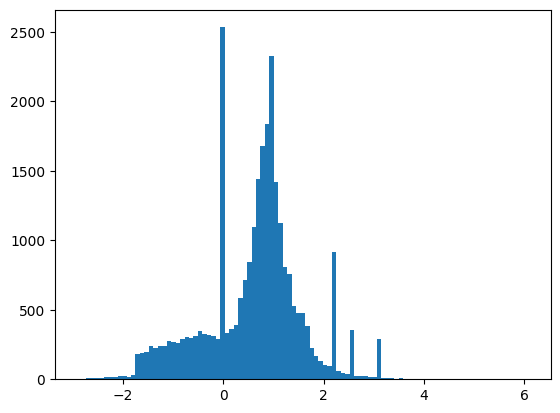

In [41]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

In [42]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

In [43]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [44]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [45]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [46]:
#procedura szkolenia modelu
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

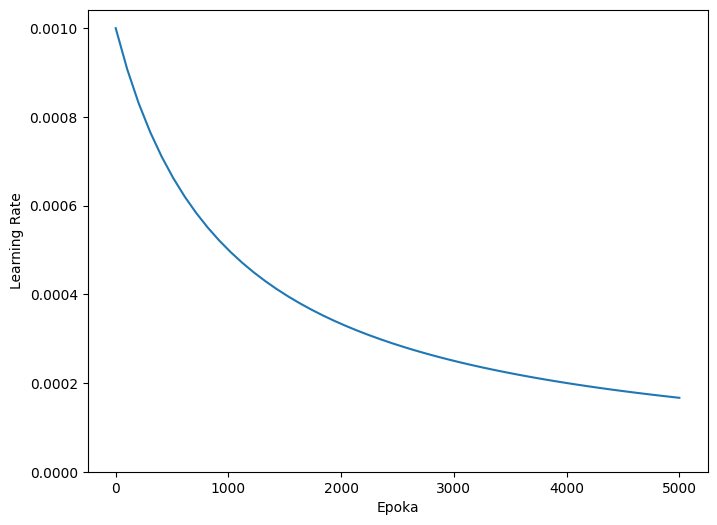

In [47]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoka')
_ = plt.ylabel('Learning Rate')

In [48]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name)
  ]

In [49]:
def compile_and_fit(model,name,optimizer=None,max_epoch=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = [
                    tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),'accuracy'
                ]
  )
  model.summary()
  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epoch,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose=0
  )
  return history

In [50]:
#bardzo mały model (tiny)
tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [51]:
size_histories = {}

In [52]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4742,  binary_crossentropy:0.7603,  loss:0.7603,  val_accuracy:0.4600,  val_binary_crossentropy:0.7134,  val_loss:0.7134,  
....................................................................................................
Epoch: 100, accuracy:0.5935,  binary_crossentropy:0.6267,  loss:0.6267,  val_accuracy:0.5680,  val_binary_crossentropy:0.6306,  val_loss:0.6306,  
..........................................................

(0.5, 0.7)

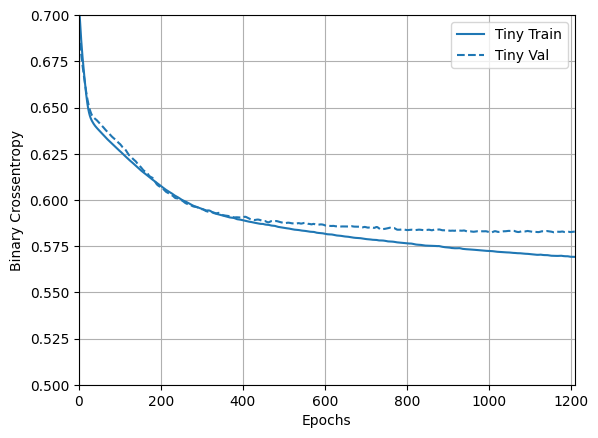

In [53]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [54]:
#mały model (small)
small_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(16,activation='elu'),
    layers.Dense(1)
])

In [55]:
size_histories['Small'] = compile_and_fit(small_model,'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                464       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5070,  binary_crossentropy:0.7868,  loss:0.7868,  val_accuracy:0.4770,  val_binary_crossentropy:0.7064,  val_loss:0.7064,  
....................................................................................................
Epoch: 100, accuracy:0.6239,  binary_crossentropy:0.6177,  loss:0.6177,  

In [58]:
#model średni (medium)
medium_model = tf.keras.Sequential([
    layers.Dense(64,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(64,activation='elu'),
    layers.Dense(64,activation='elu'),
    layers.Dense(1)
])

In [57]:
size_histories['Medium'] = compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                1856      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5069,  binary_crossentropy:0.6891,  loss:0.6891,  val_accuracy:0.4730,  val_binary_crossentropy:0.6796,  val_loss:0.6796,  
....................................

In [67]:
#duży średni (large)
large_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(1)
])

In [61]:
size_histories['large'] = compile_and_fit(large_model,"sizes/large")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dense_23 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5166,  binary_crossentropy

Text(0.5, 0, 'Epoki [skala log]')

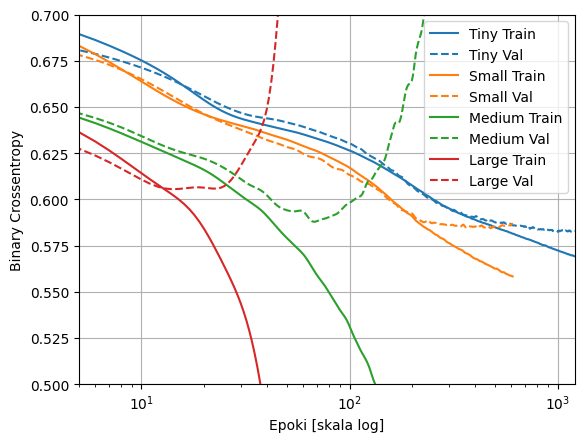

In [62]:
#wykreślenie straty dla każdego z trenowanych modeli
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epoki [skala log]")

In [63]:
shutil.rmtree(logdir/'regularizers/Tiny',ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpd79lr6xz/tensorboard_logs/regularizers/Tiny')

In [66]:
regularizers_histories = {}
regularizers_histories['Tiny']=size_histories['Tiny']

In [65]:
#Jak poradzić sobie overfitingiem 
#Regularyzacja wag (L1 i L2) -> L1 - koszt poroporcjonalny do współczynników wag
#-> L2 - koszt poroporcjonalny do kwadratów współczynników wag

l2_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001),input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)         
])

regularizers_histories['l2']=compile_and_fit(l2_model,"regularizers/l2")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dense_28 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4958,  binary_crossentropy

(0.5, 0.7)

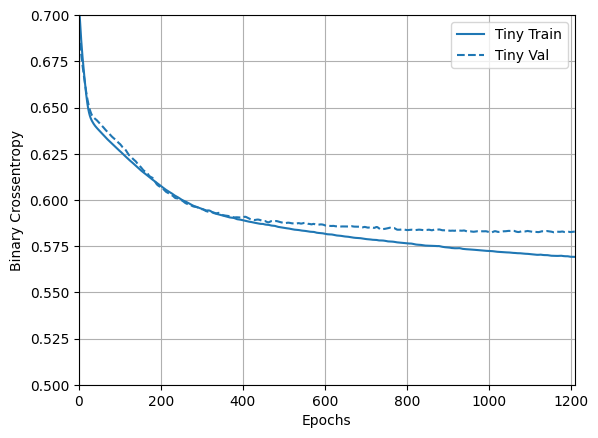

In [68]:
plotter.plot(regularizers_histories)
plt.ylim([0.5,0.7])

In [ ]:
#regularyzacja za pomocą odrzucenia -> dropout
dropout_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizers_histories['dropout']=compile_and_fit(dropout_model,"regularizers/dropout")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 512)              

In [ ]:
plotter.plot(regularizers_histories)
plt.ylim([0.5,0.7])